In [323]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Generated Cluster Data

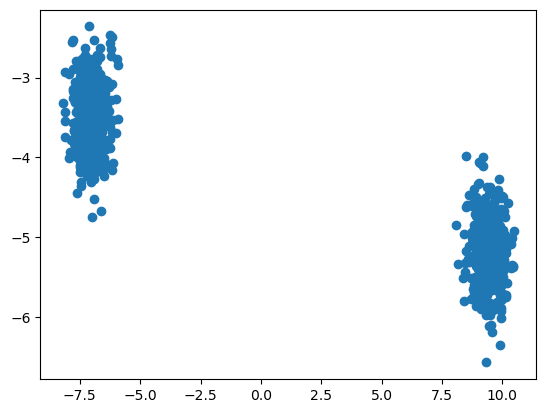

In [324]:
features, clusters = make_blobs(n_samples = 1000,
                  n_features = 2, 
                  centers = 2,
                  cluster_std = 0.4,
                  shuffle = True)
plt.scatter(features[:,0], features[:,1])
plt.show()

# Custom Made Model

float64


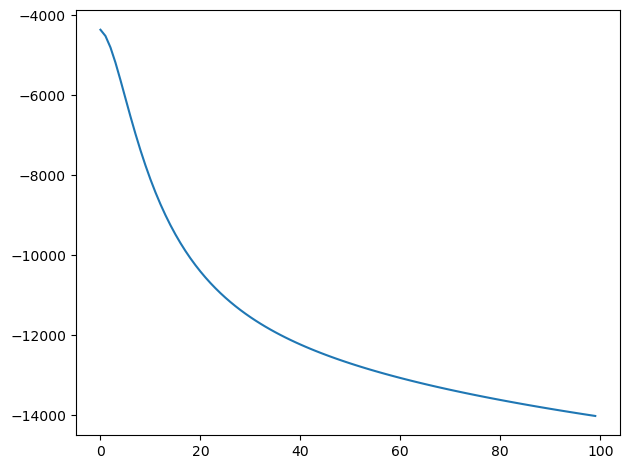

In [325]:
import torch
import torch.nn as nn

class MultivariateGaussian(nn.Module):
    def __init__(self):
        super(MultivariateGaussian, self).__init__()
        self.mu = nn.Parameter(torch.ones(2, dtype=torch.float64).normal_()) # random mean
        self.L = nn.Parameter(torch.ones(2, 2, dtype=torch.float64).normal_()) # random covar matrix
    
    def forward(self, x):
        N, D = x.shape
        x_mu = x - self.mu
        sigma = self.L @ self.L.T + torch.eye(2)
        
        log_likelihood = 0.5 * (N * D * np.log(2 * np.pi) + N * 2. * torch.sum(torch.log(torch.diag(sigma))) + torch.sum((x_mu @ torch.inverse(sigma))**2, dim=-1))
        loss = -torch.mean(log_likelihood)
        return loss


model = MultivariateGaussian()
optimizer = torch.optim.SGD([model.mu, model.L], lr=0.0001, momentum=0.9)

losses = np.zeros(100)
print(features.dtype)
# During training
for i in range(100):
    optimizer.zero_grad()
    loss = model(torch.from_numpy(features))
    loss.backward()
    optimizer.step()
    losses[i] = loss.data.cpu().numpy()

plt.figure()
plt.plot(losses)
plt.tight_layout()
plt.show()

In [359]:
import torch
import torch.nn as nn

class MultivariateGaussian(nn.Module):
    def __init__(self, n_gaussians, k_features):
        super(MultivariateGaussian, self).__init__()
        
        self.n_gaussians = n_gaussians
        self.k_features = k_features
        
        self.w = nn.Parameter(torch.ones(n_gaussians))
        self.mu = nn.ParameterList([torch.ones(k_features, dtype=torch.float64).normal_() for _ in range(n_gaussians)]) # random mean
        self.L = nn.ParameterList([torch.ones(k_features, k_features, dtype=torch.float64).normal_() for _ in range(n_gaussians)]) # random covar matrix
    
    def forward(self, x):
        loss = 0
        w = torch.softmax(self.w, dim=0)
        
        for i in range(self.n_gaussians):
            N, D = x.shape
            x_mu = x - self.mu[i]
            sigma = self.L[i] @ self.L[i].T + torch.eye(2)
            
            latent_term = 1 / (torch.sqrt(math.pow(2*math.pi, 2) * torch.det(sigma)))
            exp_term = torch.exp(-0.5 * (x_mu.T @ torch.inverse(sigma) * x_mu))
            likelihood = latent_term * exp_term
            
            log_likelihood = torch.log(likelihood)
            log_likelihood = self.w[i] * log_likelihood
            loss = torch.mean(log_likelihood)
            return loss


model = MultivariateGaussian(2, 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

losses = np.zeros(1000)
print(features.dtype)
# During training
for i in range(1000):
    optimizer.zero_grad()
    loss = model(torch.from_numpy(features))
    loss.backward()
    optimizer.step()
    losses[i] = loss.data.cpu().numpy()

plt.figure()
plt.plot(losses)
plt.tight_layout()
plt.show()

float64


RuntimeError: linalg.det: A must be batches of square matrices, but they are 1 by 2 matrices

In [348]:
model.mu

ParameterList(
    (0): Parameter containing: [torch.float64 of size 2]
    (1): Parameter containing: [torch.float64 of size 2]
)

In [349]:
from scipy.stats import multivariate_normal

def plot_gaussian_contours(means, covs, xy_points):
    x, y = np.linspace(-10, 10, 500), np.linspace(-10, 10, 500)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    for mean, cov in zip(means, covs):
        sigma_tmp = (cov @ cov.T + torch.eye(2))
        sigma_tmp = sigma_tmp.data.cpu().numpy()
        
        mean_tmp = mean.data.cpu().numpy()
        
        rv = multivariate_normal(mean_tmp, sigma_tmp)
        plt.contour(X, Y, rv.pdf(pos))
        plt.scatter(xy_points[:, 0], xy_points[:, 1])
    plt.show()

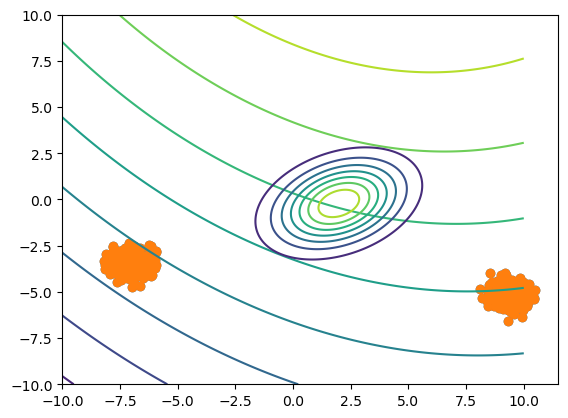

In [350]:
plot_gaussian_contours(model.mu, model.L, features)

# GMM Mixture Model

In [251]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=1, random_state=0).fit(features)

In [36]:
gm.means_

array([[10.03702335, -6.65538559]])